#  Cloth Simulation


## Tout d'abord on doit créer une simulation de tissu. Le tissu ne sera qu'un avion subdivisé.

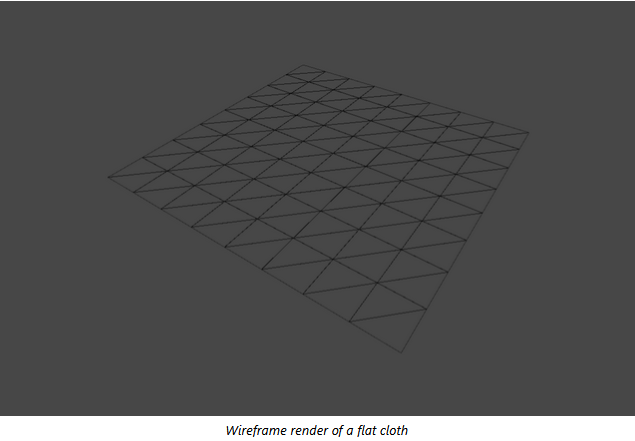

## Objectif général

Créer un simulation de tissu sur GPU en utilisant:
 - un Compute Shader pour mettre à jour les positions / vitesses des vertices.
 - Une géométrie de tissu générée sur le CPU (un simple plan subdivisé).
 - Des ressorts (springs) pour simuler le comportement du tissu.
 - une collision avec une shpère, avec friction et comportement physique réaliste.


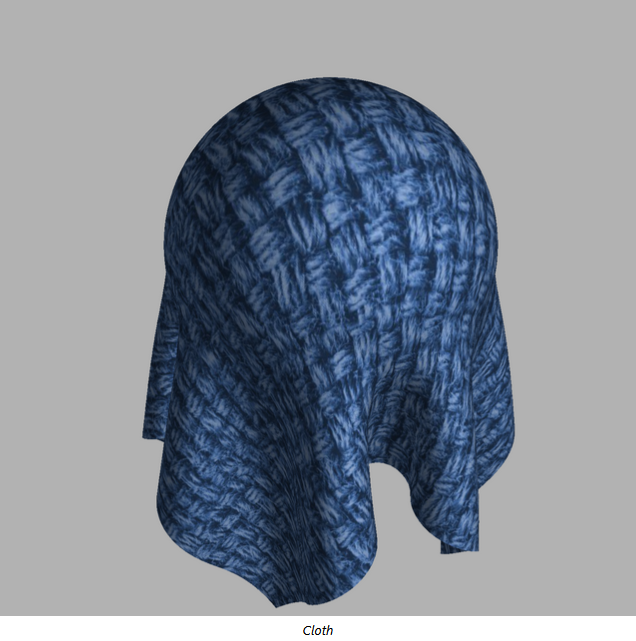
 

## Ce qu'on doit avoir côté CPU 

La géométrie du tissu et la connectivité des ressorts seront générées sur le CPU. La simulation doit fonctionner sur le GPU avec un Obturateur de calcul. Les paramètres de simulation doivent provenir du code CPU via les groupes de liaison.

1) Génération du tissu
sur le CPU, on doit créer :
- un plan subdivisé (par exemple une grille)
- le tableau des postions initiales
- le tableau des vitesses initiales (v = 0)
- la connectivité des ressorts:
    - Structural springs
    - Shear springs 
    - Bend springs
``` il faut tenir compte du nombre de subdivisions car elle doit être modifiable facilement```


2) Envoi des paramètres au GPU (Bind Groups)

On doit envoyer au compute shader:

- le rayon et la position de la sphère
- les constantes:
    - stiffness des ressorts (ks)
    - Damping (kd)
    - Masse des points 
    - Gravity 
    - Collision stiffness (kc)
    - Friction coefficient (cf)
- le timestep

## Compute shader : Simulation de tissu

Dans une simulation de tissu, seul le mouvement des sommets individuels est calculé. Chaque sommet est considéré comme un corps de point avec une masse, une position et une vitesse. A chaque étape, on calcule les forces qui s'appliquent sur le sommet. La résultante des forces nous permet de calculer l'accélération. L'accélération nous permet de mettre à jour la vitesse. La vitesse nous permet de mettre à jour la position.

1) Pour chaque vertex on doit :
Calculer les forces : 
- Gravité : 

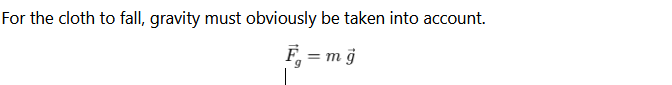

- Ressorts (Hooke's low):

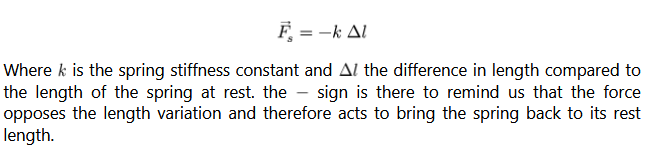

    Où est la raideur du ressort constante et la différence de longueur par rapport à la longueur du ressort au repos. le signe est là pour nous rappeler que la force s'oppose à la variation de longueur et agit donc pour ramener le ressort à sa longueur de repos.

    Pour obtenir un comportement réaliste, il est nécessaire d'avoir trois types de ressorts dans un tissu.

- structural springs : reliant les voisins directs
- shear springs :relient les diagonales
- Bend springs : relient des points espacés de 2 unités.

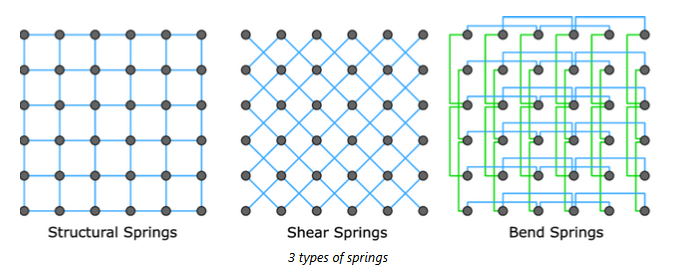

    Les constantes de rigidité de ces trois types de ressorts sont généralement différentes.

    Le problème avec les ressorts est qu'ils ont une tendance gênante à osciller. Pour réduire ce problème, une force d'amortissement est ajoutée. Cette force résiste au mouvement du ressort et est proportionnelle au taux d'extension.

- Amortissements (damping):

    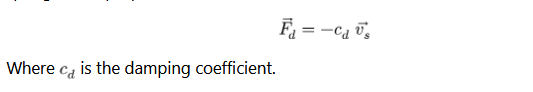


2) Mise à jour de l'accélération : 
Pour que le tissu tombe, il faut évidemment tenir compte de la gravité.

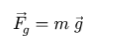

3) Mise à jour de la vitesse: 

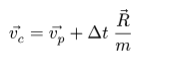  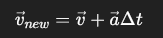



4) Msie à jour de la position: 

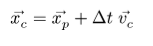 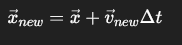










## Collision avec la sphère 

Le contact avec la sphère sera également modélisé par une force élastique:

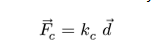

Où d est la profondeur de pénétration et k la rigidité des collisions.

on doit vérifier d'abord si la position du vertex est dans la sphère:

1) calcul de la pénétration:

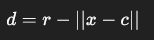

2) application de la force de collision:

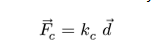

La toile ne doit jamais passer à travers la sphère


## Friction lors du contact 

Lors du contact entre le tissu et la sphère, il est possible de prendre en compte les forces de frottement. Le frottement est tangent à la surface de frottement et est calculé sur la base de la résultante des autres forces.

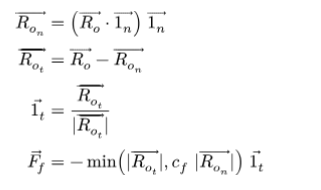

1) Projection du vecteur résultante sur :

- la composante normale :

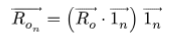

- la composante tangentielle : 

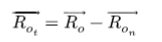

2) Calcul de la friction: 

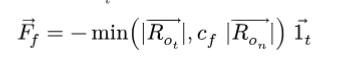


avec Ro la resultante des forces, Ron = normal et Rot la tangentiel. 1n est le vecteur unitaire normal à la surface. 1t est le vecteur unitaire tangent à la surface dans le même sens que Rot. cf est le coefficient de frottement. En bref, la force de frottement annule la composante tangentielle des autres forces jusqu'à un certain point qui dépend de la composante normale.


# Ce qu'on affiche 

Le rendering doit afficher :

- soit un wireframe 
- soit un mesh texturé 
- avec mise à jour des positions du Compute Shader chaque frame.



# Comprendre WebGPU pour la Cloth Simulation

### Ce que le WebGPU est 
je dois dire au CPU: 
- quels buffers il lit/écrit
- quels shaders il exécute
- dans quel ordre

WebGPU ne simule rien :

la physique, c'est moi (forcesn intégration, collisions).

### les 4 briques mentales indispensables

CPU (python)

- buffers : données
- shader (WGSL) : calcul
- Pipeline : comment exécuter le shader
- Bind Group : comment connecter données - shader

### Buffers : la mémoire du GPU

Règle d'or : Le GPU ne voit QUE ce que je mets dans des buffers.

ici dans ce projet :
- positions
- vitesses
- ressorts
- paramètres (gravité, dt, rayon sphère)

Tout cela c'est le buffer qui s'occupe.

---

Types importants:
- STORAGE : lecture ou écriture (positions, vitesses)
- UNIFORM : lecture seule (paramètres)
- VERTEX : affichage (render)

oral : Pourquoi séparer uniform et storage ?
Uniform = petit, constant, rapide ; storage = gros, modifiable.

---

### Shaders : le code qui tourne sur le GPU

Deux shaders dans ce projet 

1. Compute shader 
    - fait la physique
    - met à jour positions et vitesses

2. Vertex / Fragment Shader
    - affiche le tissu

Le compute shader est le coeur du projet 

Règle mentale cruciale:

```bash
1 invocation du compute shader
= 1 sommet du tissu
```

Donc 
```wgsl
@compute @workgroup_size(64)
fn main(@builtin(global_invocation_id) id: vec3<u32>) {
    let i = id.x; // index du sommet
}
```

oral : Pourquoi c’est parallélisable ?
Chaque sommet est indépendant à un pas de temps donné.

---

### Pipeline : le contrat CPU - GPU

un pipeline : voici le shader, et voici comment le GPU doit l'executer:

j'aurai:

- ComputePipeline
- RenderPipeline

je peux pas lancer un shader sans pipeline

---

### Bind Groups : le câblage 
c'est souvent le plus flou : on simplifie

- Métaphone 
    - Shader: prise électrique
    - Bind group : multiprise
    - Buffer : appareil branché 

le bind group dit: 

```csharp
binding 0 → positions
binding 1 → velocities
binding 2 → params
```
et le shader déclare EXACTEMENT la même chose:

```wgsl
@group(0) @binding(0) var<storage> positions : array<vec3<f32>>;
```
oral: 
Que se passe-t-il si l’ordre ne correspond pas ?
Bug silencieux / valeurs incohérentes.


---

### cycle d'une frame (ultra important)

Chaque frame fait :
```markdown
1) CPU envoie paramètres (dt, sphère)
2) Compute pass
   - calcul forces
   - update velocities
   - update positions
3) Render pass
   - affiche le tissu
```

compute avant render toujours.


